In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## Data exploriation and engineering

In [2]:
df_customer = pd.read_csv('data/twm_customer.csv', sep=';')
print(df_customer.shape)
df_customer.head()

(747, 15)


cust_id  income  age  years_with_bank  nbr_children gender  marital_status  \
0  1362691   26150   46                5             1     M                2   
1  1362487    6605   71                1             0     M                2   
2  1363160   18548   38                8             0     F                1   
3  1362752   47668   54                3             0     F                1   
4  1362548   44554   59                9             2     F                4   

  name_prefix                                         first_name  \
0              Donald                                        ...   
1              ChingDyi                                      ...   
2              Rosa                                          ...   
3              Lisa                                          ...   
4              Barbara                                       ...   

                                           last_name  street_nbr  \
0  Marek                                         ...        8298   
1  Moussavi                                      ...       10603   
2  Johnston                                      ...        8817   
3  Martin                                        ...         676   
4  O'Malley                                      ...        6578   

                                         street_name  postal_code  \
0  Second                                        ...        89194   
1  Daffodil                                      ...        90159   
2  Figueroa                                      ...        90024   
3  Humble                                        ...        90172   
4  C                                             ...        10138   

                                  city_name state_code  
0  Las Vegas                                      NV    
1  Los Angeles                                    CA    
2  Los Angeles                                    CA    
3  Los Angeles                                    CA    
4  New York City                                  NY

In [3]:
# missing data
total = df_customer.isnull().sum().sort_values(ascending=False)
percent = (df_customer.isnull().sum()/df_customer.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
cust_id              0      0.0
income               0      0.0
age                  0      0.0
years_with_bank      0      0.0
nbr_children         0      0.0
gender               0      0.0
marital_status       0      0.0
name_prefix          0      0.0
first_name           0      0.0
last_name            0      0.0
street_nbr           0      0.0
street_name          0      0.0
postal_code          0      0.0
city_name            0      0.0
state_code           0      0.0

In [4]:
df_filtered = df_customer.drop(['cust_id', 'name_prefix', 'first_name', 'last_name', 'street_nbr', 'street_name', 'postal_code'], axis=1)
df_filtered.head()

income  age  years_with_bank  nbr_children gender  marital_status  \
0   26150   46                5             1     M                2   
1    6605   71                1             0     M                2   
2   18548   38                8             0     F                1   
3   47668   54                3             0     F                1   
4   44554   59                9             2     F                4   

                                  city_name state_code  
0  Las Vegas                                      NV    
1  Los Angeles                                    CA    
2  Los Angeles                                    CA    
3  Los Angeles                                    CA    
4  New York City                                  NY

## K-means with numeric variables

In [5]:
df_num = df_filtered.drop(['gender','city_name', 'state_code', 'marital_status'], axis=1)
df_num.head()

income  age  years_with_bank  nbr_children
0   26150   46                5             1
1    6605   71                1             0
2   18548   38                8             0
3   47668   54                3             0
4   44554   59                9             2

In [6]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_scaled = sc.fit_transform(df_num)

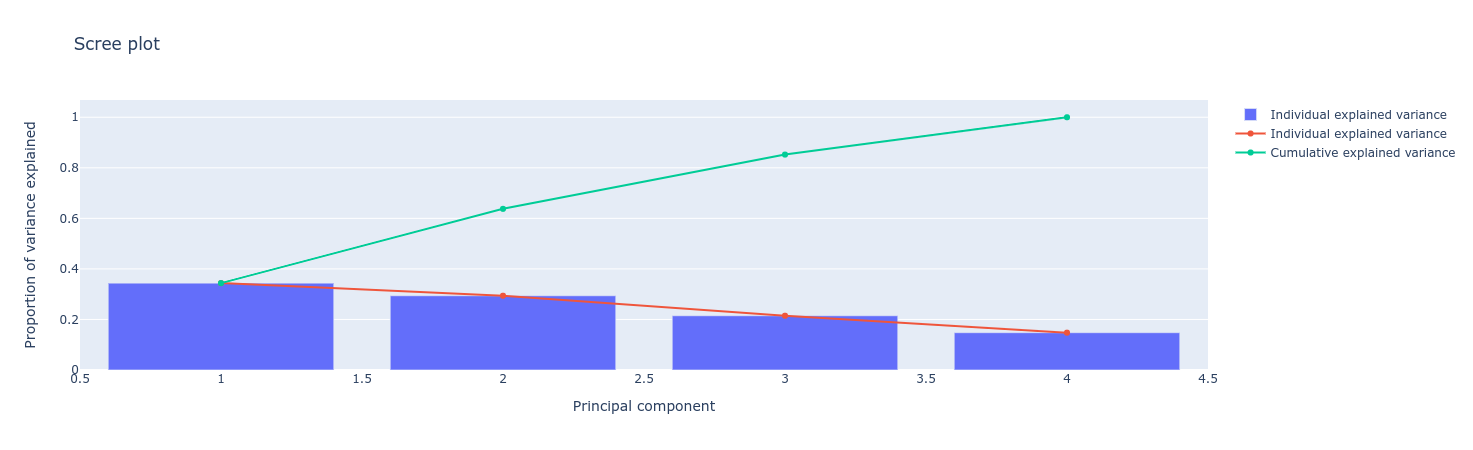

In [7]:
import plotly.graph_objects as go

pca = sklearnPCA(n_components=df_scaled.shape[1])
df_pca = pca.fit_transform(df_scaled)

x = np.arange(1, df_scaled.shape[1] + 1)

fig = go.Figure()

fig.add_trace(go.Bar(x=x, y=pca.explained_variance_ratio_, name='Individual explained variance'))

fig.add_trace(go.Scatter(x=x, y=pca.explained_variance_ratio_, name='Individual explained variance'))

fig.add_trace(go.Scatter(x=x, y=np.cumsum(pca.explained_variance_ratio_), name='Cumulative explained variance'))

fig.update_layout(title='Scree plot',
                   xaxis_title='Principal component',
                   yaxis_title='Proportion of variance explained')
fig.show()

In [8]:
# set figure size
plt.rcParams["figure.figsize"] = (12,8)

def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

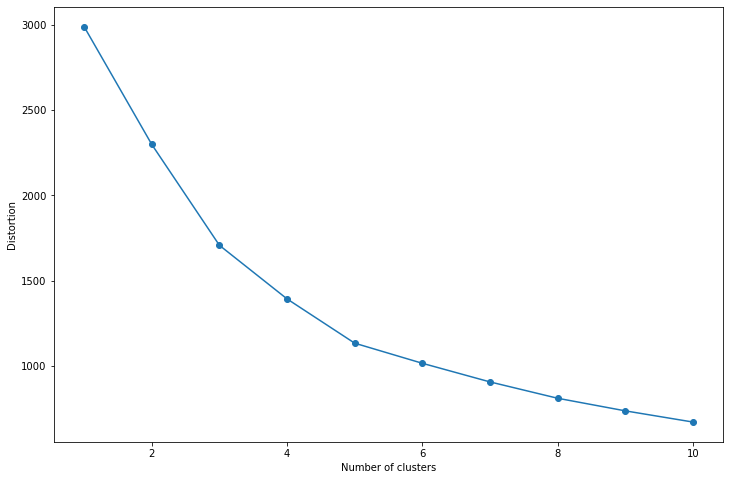

In [9]:
plot_distortion(df_scaled,max_clusters=10)

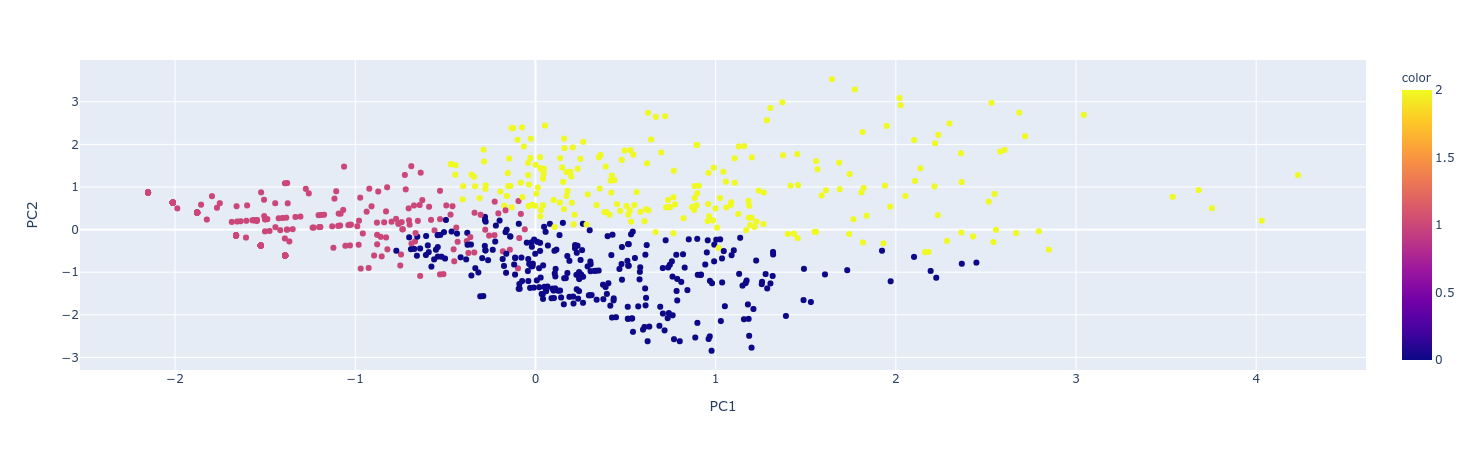

In [10]:
km = KMeans(n_clusters=3,
            n_init=10)

y_km = km.fit_predict(df_scaled)

pca = sklearnPCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
fig = px.scatter(df_pca, x=0, y=1, color=y_km, labels={'0':'PC1', '1':'PC2'})
fig.show()

In [11]:
df_final = pd.DataFrame(df_scaled, columns = df_num.columns)
df_final.head()

income       age  years_with_bank  nbr_children
0  0.154185  0.184312         0.408539      0.258591
1 -0.726524  1.493070        -1.087435     -0.648298
2 -0.188366 -0.234490         1.530520     -0.648298
3  1.123798  0.603115        -0.339448     -0.648298
4  0.983479  0.864867         1.904514      1.165479

In [12]:
df_final['category'] = y_km
df_final.head()

income       age  years_with_bank  nbr_children  category
0  0.154185  0.184312         0.408539      0.258591         0
1 -0.726524  1.493070        -1.087435     -0.648298         0
2 -0.188366 -0.234490         1.530520     -0.648298         0
3  1.123798  0.603115        -0.339448     -0.648298         0
4  0.983479  0.864867         1.904514      1.165479         2

## Radar plots

In [13]:
means0 = df_final[df_final['category'] == 0].mean(axis=0)[:-1]
means1 = df_final[df_final['category'] == 1].mean(axis=0)[:-1]
means2 = df_final[df_final['category'] == 2].mean(axis=0)[:-1]

In [14]:
features = list(df_final.columns)[:-1]

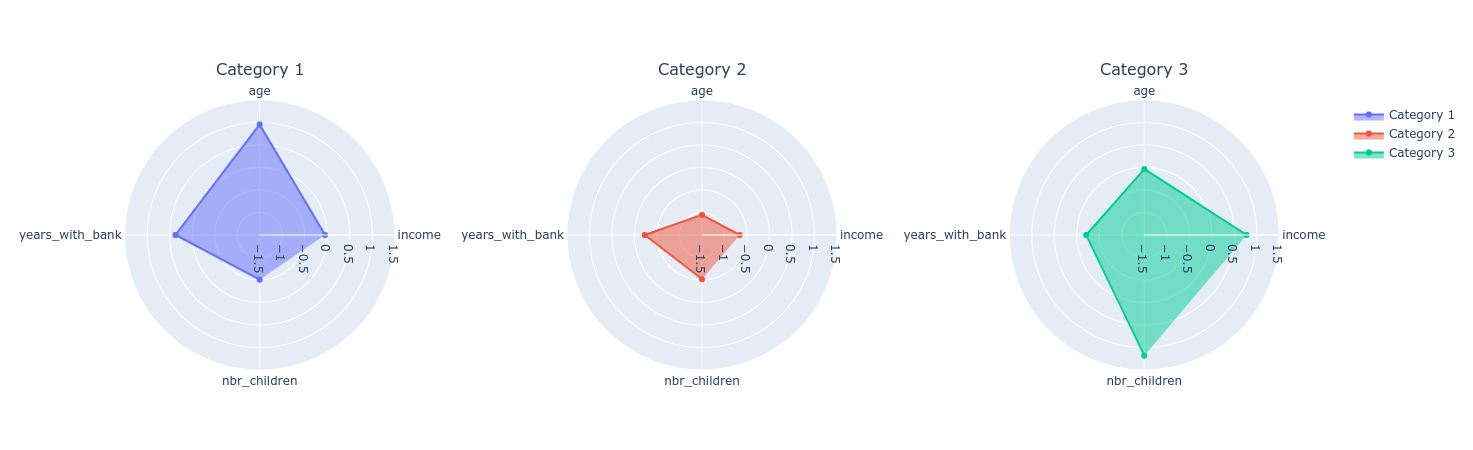

In [15]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]],
                   subplot_titles=("Category 1","Category 2","Category 3"))

fig.add_trace(
go.Scatterpolar(
  r= means0,
  theta= features,
  fill='toself',
  name='Category 1'
), row=1, col=1)

fig.add_trace(
go.Scatterpolar(
  r= means1,
  theta= features,
  fill='toself',
  name='Category 2'
), row=1, col=2)

fig.add_trace(
go.Scatterpolar(
  r= means2,
  theta= features,
  fill='toself',
  name='Category 3'
), row=1, col=3)

fig.update_polars(radialaxis={'range': [-1.5,1.5]})
fig.update_annotations(yshift=20)
fig.show()

In [16]:
df_final_categories = pd.concat([df_final, df_filtered.iloc[:,4:]], axis=1 )
df_final_categories.head()

income       age  years_with_bank  nbr_children  category gender  \
0  0.154185  0.184312         0.408539      0.258591         0     M    
1 -0.726524  1.493070        -1.087435     -0.648298         0     M    
2 -0.188366 -0.234490         1.530520     -0.648298         0     F    
3  1.123798  0.603115        -0.339448     -0.648298         0     F    
4  0.983479  0.864867         1.904514      1.165479         2     F    

   marital_status                                 city_name state_code  
0               2  Las Vegas                                      NV    
1               2  Los Angeles                                    CA    
2               1  Los Angeles                                    CA    
3               1  Los Angeles                                    CA    
4               4  New York City                                  NY

## Checking categorical variables

In [17]:
df_male = df_final_categories[df_final_categories['gender'] == 'M '].iloc[:,:5]
df_female = df_final_categories[df_final_categories['gender'] == 'F '].iloc[:,:5]

In [18]:
male_means = df_male.groupby(['category']).mean()
female_means = df_female.groupby(['category']).mean()

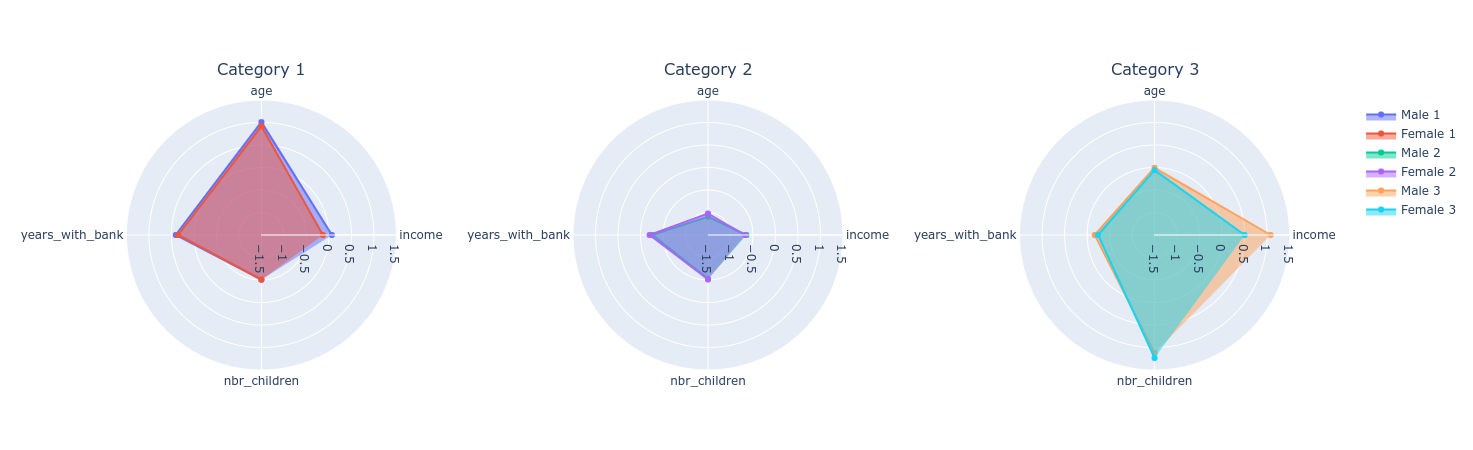

In [19]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]],
                   subplot_titles=("Category 1","Category 2","Category 3"))

#############################################

fig.add_trace(
go.Scatterpolar(
  r= male_means.iloc[0,:],
  theta= features,
  fill='toself',
  name='Male 1'
), row=1, col=1)

fig.add_trace(
go.Scatterpolar(
  r= female_means.iloc[0,:],
  theta= features,
  fill='toself',
  name='Female 1'
), row=1, col=1)

#############################################

fig.add_trace(
go.Scatterpolar(
  r= male_means.iloc[1,:],
  theta= features,
  fill='toself',
  name='Male 2'
), row=1, col=2)

fig.add_trace(
go.Scatterpolar(
  r= female_means.iloc[1,:],
  theta= features,
  fill='toself',
  name='Female 2'
), row=1, col=2)

#############################################

fig.add_trace(
go.Scatterpolar(
  r= male_means.iloc[2,:],
  theta= features,
  fill='toself',
  name='Male 3'
), row=1, col=3)
    
fig.add_trace(
go.Scatterpolar(
  r= female_means.iloc[2,:],
  theta= features,
  fill='toself',
  name='Female 3'
), row=1, col=3)
    
###########################################

fig.update_polars(radialaxis={'range': [-1.5,1.5]})
fig.update_annotations(yshift=20)
fig.show()

### Marital

In [20]:
df_final_categories = df_final_categories.replace({'marital_status':{1:'S', 2:'M', 3:'W', 4:'D'}})
df_final_categories.head()

income       age  years_with_bank  nbr_children  category gender  \
0  0.154185  0.184312         0.408539      0.258591         0     M    
1 -0.726524  1.493070        -1.087435     -0.648298         0     M    
2 -0.188366 -0.234490         1.530520     -0.648298         0     F    
3  1.123798  0.603115        -0.339448     -0.648298         0     F    
4  0.983479  0.864867         1.904514      1.165479         2     F    

  marital_status                                 city_name state_code  
0              M  Las Vegas                                      NV    
1              M  Los Angeles                                    CA    
2              S  Los Angeles                                    CA    
3              S  Los Angeles                                    CA    
4              D  New York City                                  NY

In [21]:
df_married = df_final_categories[df_final_categories['marital_status'] == 'M'].iloc[:,:5]
df_single = df_final_categories[df_final_categories['marital_status'] == 'S'].iloc[:,:5]
df_divorced = df_final_categories[df_final_categories['marital_status'] == 'D'].iloc[:,:5]
df_widowed = df_final_categories[df_final_categories['marital_status'] == 'W'].iloc[:,:5]

In [22]:
df_married_means = df_married.groupby(['category']).mean()
df_single_means = df_single.groupby(['category']).mean()
df_divorced_means = df_divorced.groupby(['category']).mean()
df_widowed_means = df_widowed.groupby(['category']).mean()

means = {'Married': df_married_means, 'Single': df_single_means, 
         'Divorced': df_divorced_means, 'Widowed': df_widowed_means}


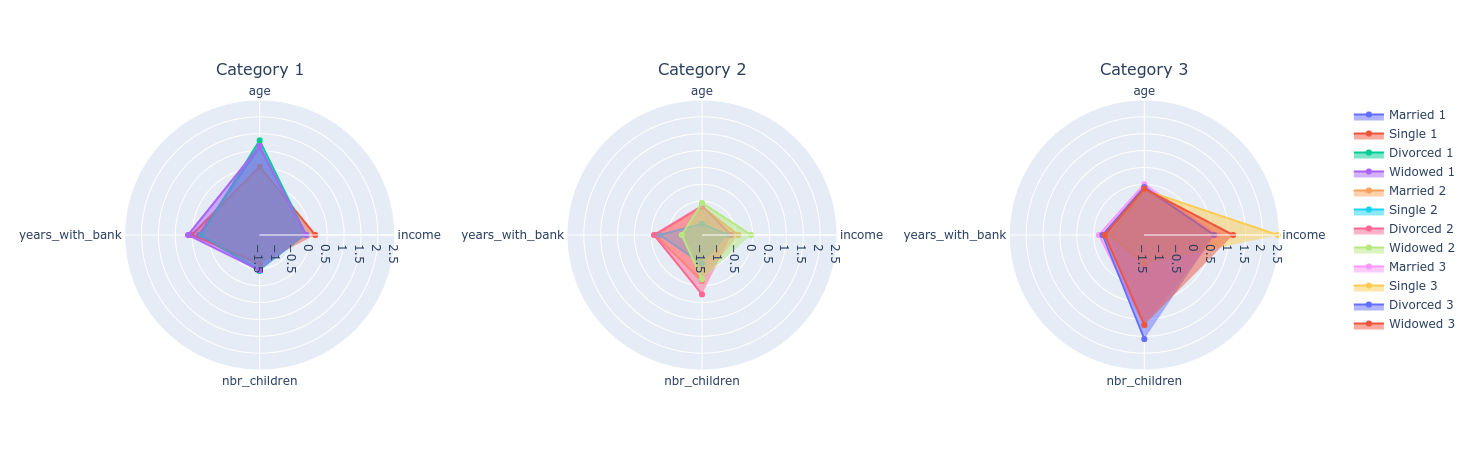

In [23]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]],
                   subplot_titles=("Category 1","Category 2","Category 3"))

for feature in range(3):

    for key, value in means.items():
        
        fig.add_trace(
        go.Scatterpolar(
          r= value.iloc[feature,:],
          theta= features,
          fill='toself',
          name=key + " " + str(feature+1)
        ), row=1, col=feature+1)

fig.update_polars(radialaxis={'range': [-1.5,2.5]})
fig.update_annotations(yshift=20)
fig.show()

### Regional Data

In [24]:
regions = pd.read_csv('data/us_census_bureau_regions_and_divisions.csv')
regions.head()

State State Code Region            Division
0      Alaska         AK   West             Pacific
1     Alabama         AL  South  East South Central
2    Arkansas         AR  South  West South Central
3     Arizona         AZ   West            Mountain
4  California         CA   West             Pacific

In [25]:
regions['Region'].value_counts()

South        17
West         13
Midwest      12
Northeast     9
Name: Region, dtype: int64

In [26]:
#regions = regions.drop(['State','Division'], axis=1)
regions.rename(columns={'State Code': 'state_code'}, inplace=True)
regions.head()

State state_code Region            Division
0      Alaska         AK   West             Pacific
1     Alabama         AL  South  East South Central
2    Arkansas         AR  South  West South Central
3     Arizona         AZ   West            Mountain
4  California         CA   West             Pacific

In [27]:
df_final_categories['state_code'] = df_final_categories['state_code'].str.strip()

In [28]:
print(df_final_categories.shape)
df_regional = pd.merge(df_final_categories, regions, how='left', on='state_code')
df_regional.head()

(747, 9)


income       age  years_with_bank  nbr_children  category gender  \
0  0.154185  0.184312         0.408539      0.258591         0     M    
1 -0.726524  1.493070        -1.087435     -0.648298         0     M    
2 -0.188366 -0.234490         1.530520     -0.648298         0     F    
3  1.123798  0.603115        -0.339448     -0.648298         0     F    
4  0.983479  0.864867         1.904514      1.165479         2     F    

  marital_status                                 city_name state_code  \
0              M  Las Vegas                                        NV   
1              M  Los Angeles                                      CA   
2              S  Los Angeles                                      CA   
3              S  Los Angeles                                      CA   
4              D  New York City                                    NY   

        State     Region         Division  
0      Nevada       West         Mountain  
1  California       West          Pacific  
2  California       West          Pacific  
3  California       West          Pacific  
4    New York  Northeast  Middle Atlantic

In [29]:
df_regional.shape

(747, 12)

In [30]:
# missing data
total = df_regional.isnull().sum().sort_values(ascending=False)
percent = (df_regional.isnull().sum()/df_regional.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
State                3  0.004016
Region               3  0.004016
Division             3  0.004016
income               0  0.000000
age                  0  0.000000
years_with_bank      0  0.000000
nbr_children         0  0.000000
category             0  0.000000
gender               0  0.000000
marital_status       0  0.000000
city_name            0  0.000000
state_code           0  0.000000

In [31]:
df_regional.sort_values(by=['Region']).tail()

income       age  years_with_bank  nbr_children  category gender  \
393 -0.314626 -0.653293        -1.461429      2.072368         2     M    
746 -0.218692 -1.281497        -0.339448     -0.648298         1     F    
33   0.612901  0.184312         0.782533      0.258591         0     M    
127 -0.401818  0.393714        -1.461429     -0.648298         1     F    
380 -0.114872  0.341363         1.904514      0.258591         0     F    

    marital_status                                 city_name state_code  \
393              M  San Jose                                         CA   
746              S  Los Angeles                                      CA   
33               M  Omaha                                            NB   
127              W  Omaha                                            NB   
380              M  Omaha                                            NB   

          State Region Division  
393  California   West  Pacific  
746  California   West  Pacific  
33          NaN    NaN      NaN  
127         NaN    NaN      NaN  
380         NaN    NaN      NaN

In [32]:
df_regional.fillna({'Region': 'Midwest'}, inplace=True)

In [33]:
df_south = df_regional[df_regional['Region'] == 'South'].iloc[:,:5]
df_west = df_regional[df_regional['Region'] == 'West'].iloc[:,:5]
df_midwest = df_regional[df_regional['Region'] == 'Midwest'].iloc[:,:5]
df_northeast = df_regional[df_regional['Region'] == 'Northeast'].iloc[:,:5]

In [34]:
df_south_means = df_south.groupby(['category']).mean()
df_west_means = df_west.groupby(['category']).mean()
df_midwest_means = df_midwest.groupby(['category']).mean()
df_northeast_means = df_northeast.groupby(['category']).mean()

means = {'South': df_south_means, 'West': df_west_means, 
         'Midwest': df_midwest_means, 'Northeast': df_northeast_means}

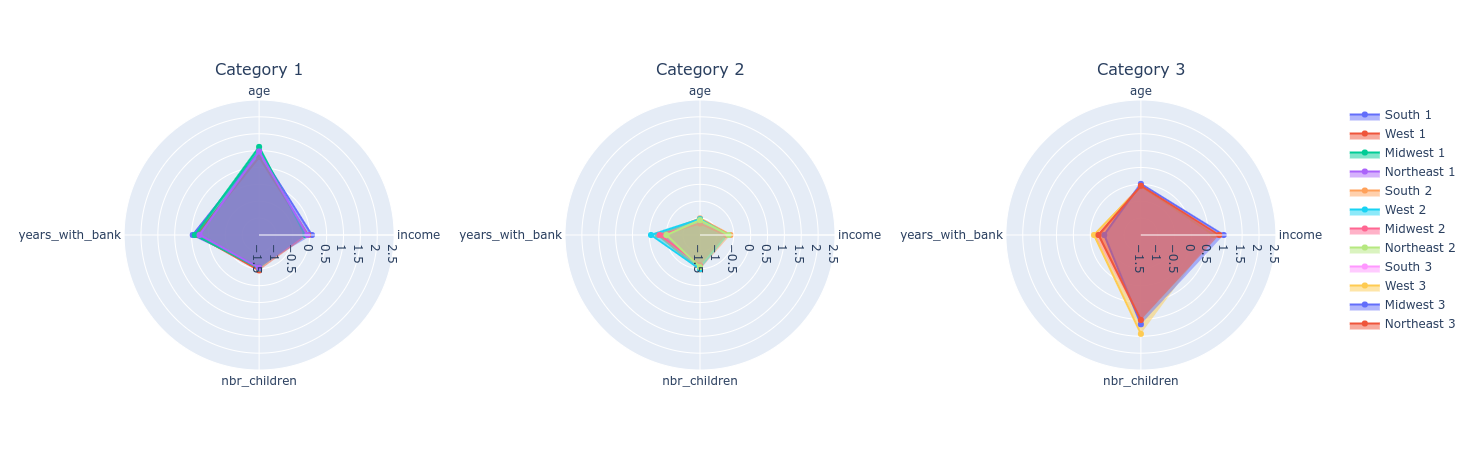

In [35]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]],
                   subplot_titles=("Category 1","Category 2","Category 3"))

for feature in range(3):

    for key, value in means.items():
        
        fig.add_trace(
        go.Scatterpolar(
          r= value.iloc[feature,:],
          theta= features,
          fill='toself',
          name=key + " " + str(feature+1)
        ), row=1, col=feature+1)

fig.update_polars(radialaxis={'range': [-1.5,2.5]})
fig.update_annotations(yshift=20)
fig.show()

In [36]:
df_pca = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'], index=list(df_num.columns))

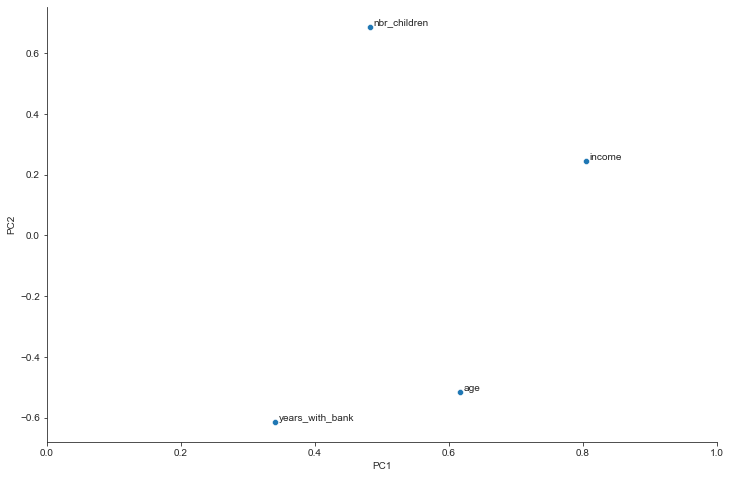

In [37]:
loading_properties = list(df_num.columns)
sns.set_style('ticks')
sns.scatterplot(x='PC1', y='PC2', data=loadings_df)

for i in range(len(loading_properties)):
    plt.text(loadings_df.iloc[i]['PC1']+0.005, loadings_df.iloc[i]['PC2']+0.005, loading_properties[i])

sns.despine()
plt.xlim(0,1)
plt.show()